# San Diego Crime Time Series Heat Maps

This analysis will examine six years of data that was aggregated by SANDAG and processed by the [San Diego Regional Data Library](http://sandiegodata.org) to visualize crime patterns on a weekly and hourly basis. The analysis uses 403,919 crime incidents.

The data is published in CSV and shapefile form at the [Library's data repository](http://data.sandiegodata.org/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract), but this analysis uses an updated dataset that is only available through Ambry. 


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
incidents_url='https://s3.amazonaws.com/s3.sandiegodata.org/repo/clarinova.com/crime-incidents-casnd-7ba4-r3/incidents-5y.csv'
# 100K set, for testing. 
#incidents_url = 'https://s3.amazonaws.com/s3.sandiegodata.org/repo/clarinova.com/crime-incidents-casnd-7ba4-r3/incidents-100k.csv'
inct = pd.read_csv(incidents_url)

inct['time'] = pd.to_datetime(inct.time)
inct['date'] = pd.to_datetime(inct.date)
inct['id'] = inct.index # Legacy of earlier dataset

In [3]:
inct['dtime'] = inct['hour'].astype('float64') + inct.time.dt.minute/60.0
inct['qtime'] = (inct['dtime'] * 4).astype('int')

inct['legend'] = inct.type # Legacy

legends = [u'ASSAULT',u'ROBBERY',u'VEHICLE BREAK-IN/THEFT', u'BURGLARY',
        u'THEFT/LARCENY',u'SEX CRIMES',u'DRUGS/ALCOHOL VIOLATIONS',u'DUI']

legends

['ASSAULT',
 'ROBBERY',
 'VEHICLE BREAK-IN/THEFT',
 'BURGLARY',
 'THEFT/LARCENY',
 'SEX CRIMES',
 'DRUGS/ALCOHOL VIOLATIONS',
 'DUI']

# Hour and Day of Week Heatmaps

These heat maps are square grids where each hour of the week is represented by a cell. The vertical axis is hour of day, and the horizontal axis is day of week, with Sunday being the area between 0 and 1, etc.  The color indicates the number of crimes in that hour of the week, with red being larger than yellow. Note that each grid is scaled independently, so a red square in one heatmap is not comparable to a red square in another heatmap. This visualization is only for looking at the paterns of crimes over time; it doesn't tell you anything about the number of crimes, except the relative relationship between hours in a single grid.

There are three types of incidents:
* Crime Cases
* Arrests
* Citations

However, this version of the dataset doesn't have the column from the original dataset that has these values, so this analysis will include all of them. 

There are 12 crime categories, expressed as the codes established by the FBI. ( UCR codes. )

First we will look at all of the incidents in the city, and then by each type. A grid is blank when there are fewer than 40 incidents of that  type and category. 

In [4]:
from math import ceil

def plot_heat_grid(df, legends = None, title=None, filename=None):
    import numpy as np
    import matplotlib.pyplot as plt

    if not legends:
        legends = sorted([ l for l in df.legend.unique() if l.strip() and l not in ('-', 'ARSON','HOMICIDE') ])

    c = len(legends)
    ncols = 4.
    nrows = ceil(float(c)/ncols)

    cmap = plt.get_cmap('YlOrRd')

    fig, axes = plt.subplots(nrows=int(nrows), ncols=int(ncols), figsize=(10,10), 
                             squeeze=True, sharex=False, sharey=False)

    fig.set_size_inches(ncols*2.5,nrows*2.5)
    axes = axes.ravel() # Convert 2D array to 1D
    plt.tight_layout(h_pad=2)
    fig.subplots_adjust(top=0.90)
    for i, legend in enumerate(legends):

        sub = df[df.legend == legend]
        

        axes[i].set_title(legend.title())
            
        if len(sub) < 40:
            continue
       
        heatg = sub.groupby(['dow','hour'])
        hgcounts = heatg.count()['id'].unstack('hour').fillna(0)
   
        # Converting to an array puts it into a for that
        # matplotlib expects. This probably only works b/c the
        # hours and days of week are 1-based indexes. 
        axes[i].pcolormesh(np.array(hgcounts.T),cmap=cmap)
        
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')
        
    if filename:
        fig.savefig(filename)
    


## Whole Region, By Type, By Day of Week and Hour of Day

Each rhythm map in the grid shows incidents from the whole region, with dimensions of day of week ( 0 to 7 ) and hour of the day ( 0 to 24 ) 



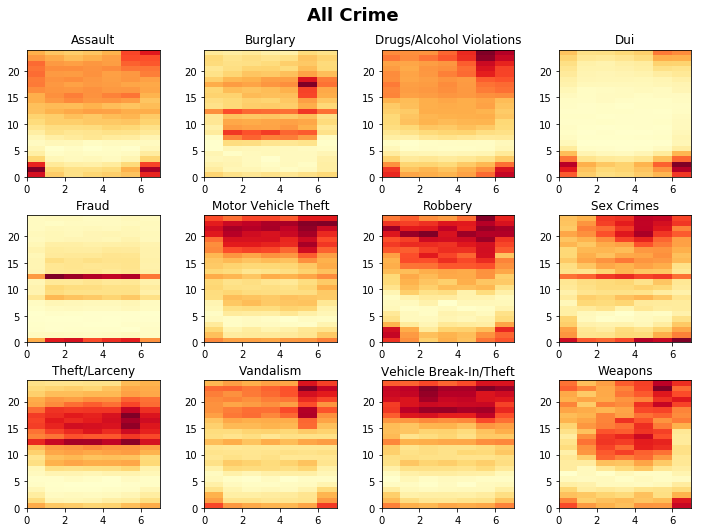

In [5]:
plot_heat_grid(inct, title='All Crime', filename='all-crime-by-type.png')

There are a lot of stories in these grids!
* A lull at 5AM every day. This is the daily crime minimum. 
* Most Personal crimes and alcohol crimes occur on weekend evenings. 
* DUIs happen around when the bars close. 
* Burglaries occur during the workday ( residential ) and Friday evenings (  commercial ) 
* Many categories have a lot of incidents at 12:00, which appears to be the default for crimes entered without a time is most visible in the Fraud and Theft heatmaps. 


# Crime Categories By Community

## Pacific Beach

Now we can see the patterns for only Pacific Beach. Pacific Beach is about 35% quiet family neighborhoods and the remainder is young singles and a rowdy strip of clubs, bars and tatoo parlors. The family neighborhoods have some of the lowest crime rates in the city, and the "Whiskey Row" has some of the highest. 

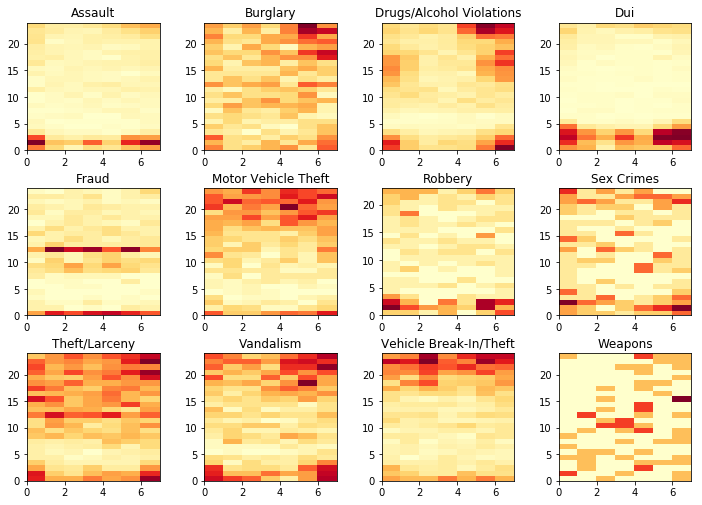

In [6]:
plot_heat_grid(inct[inct.community == 'SanPCF'])

## Downtown

This is the Downtown area. The area has an increasing number of residents, but most of the people are there for business, a low crime activity, or nightlife, a high-crime activity. The result is that the patters are similar to Pacific Beach. 

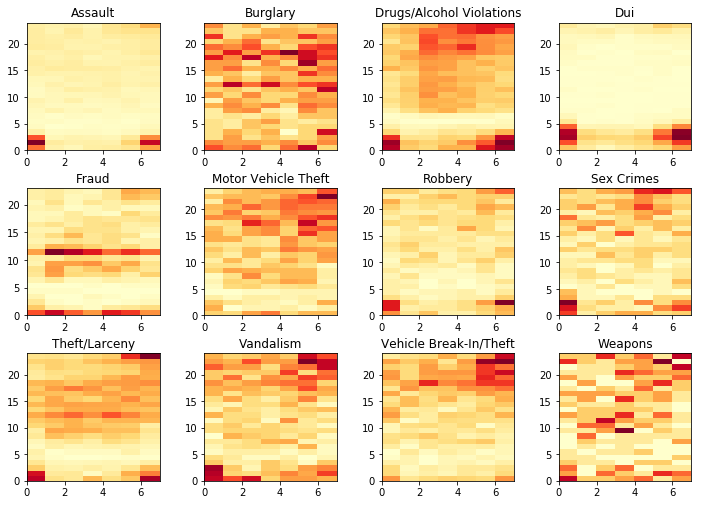

In [7]:
plot_heat_grid(inct[inct.community == 'SanDOW'])

## North Park

Here is North Park, another high-intensity nightlife area, with a specialization in prostitution. The "Sex Crimes" category has a variety of specific crimes, and in the previous maps they are all contributing, and since some of the can happen throughout the day, the maps are difuse. In North Park, prostitution dominates, and it swamps the other sex crimes, so you see a strong pattern, with prostitution peaking on Wednesday evenings. 

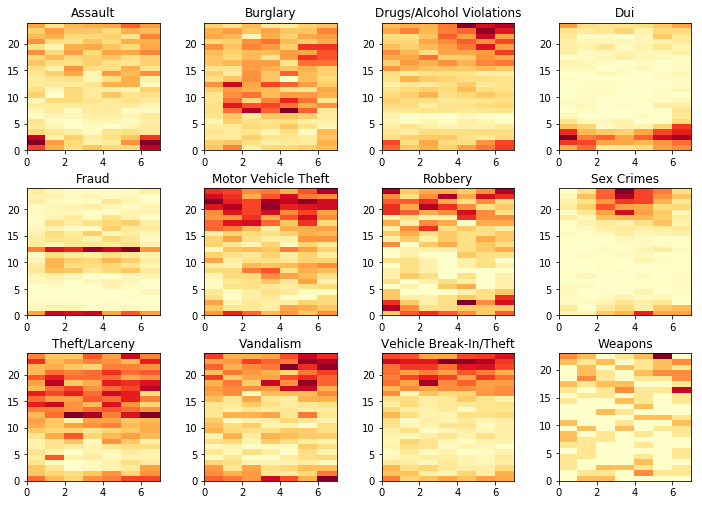

In [8]:
plot_heat_grid(inct[inct.community == 'SanGRE'])

## La Jolla

This sort of heat map analysis isn't always useful. La Jolla, which is among the wealthiest zip codes in the country, with a lot of large estates with low poulation density and a very constrained nightlife district, has too few crimes to light up the heatmaps. The result is that there are no clear patterins in most of the maps, and some don't have any crimes at some times of day. 

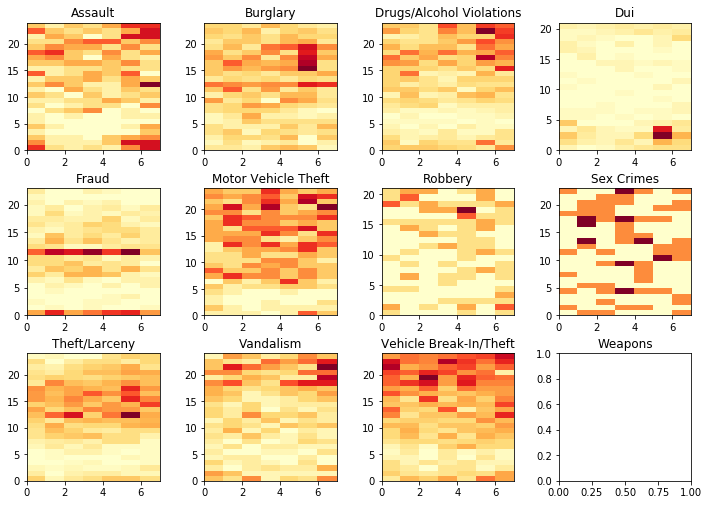

In [9]:
plot_heat_grid(inct[inct.community == 'SanLAJ'])

# Comparing Communities

The preceeding analysis lets us see which of the crime types have interesting patterns. Now let's look at how those patterns vary across communities. There there are a lot of communities, we'll pick a selection of them. The selection includes the largest communities a few of the poorest and a few of the wealthy ones. 

We can do the same analysis for each of the communities in San Diego. First, here is a list of the community codes that we'll use -- there are many more we aren't using -- , the community name, and the population. 

In [10]:
inct.head().T

,0,1,2,3,4
id,0,1,2,3,4
date,2008-01-01 00:00:00,2008-01-01 00:00:00,2008-01-01 00:00:00,2008-01-01 00:00:00,2008-01-01 00:00:00
year,2008,2008,2008,2008,2008
month,1,1,1,1,1
day,2922,2922,2922,2922,2922
week,0,0,0,0,0
dow,2,2,2,2,2
time,2017-11-12 00:00:00,2017-11-12 00:00:00,2017-11-12 00:00:00,2017-11-12 00:00:00,2017-11-12 00:00:00
hour,0,0,0,0,0
is_night,1,1,1,1,1


The communities are shown using mnemonic codes. Some of them are San Diego county cities and some are communities in San Diego City.  [There is a list of these codes with the full community names. ](https://docs.google.com/spreadsheets/d/1tvXZKjyh5tdKHF2TUbQvW0hJoSjoG6dK4pA2SD-2pu4/edit#gid=1)

In [11]:

communities = ['SanDOW','SanMDC','SanPCF','SanSOT','SanGRE','SanCLA','SanUPT','SanENC','SanUNV','SanMID',
               'SanMIR','SanSKY','SanOAT', 'SanCOL', 'SanLAJ']

(inct[['community', 'comm_pop']][inct.community.isin(communities)]
.drop_duplicates().sort_values('comm_pop', ascending=False))

,community,comm_pop
35,SanCLA,77873
174,SanMDC,74062
83,SanMIR,72761
116,SanSKY,67273
41,SanUNV,63098
140,SanOAT,60544
88,SanSOT,57358
37,SanENC,47361
187,SanGRE,45697
38,SanPCF,39849


In [12]:
# Get a list of all of the communities, ordered by population, so we can manually extract codes. 
x = inct[['legend','community']]
#x = x[x.legend == 'SEX CRIMES']
_ = x.groupby('community').count().sort_values('legend', ascending=False)


In [13]:
def plot_heat_grid_community(df,  communities=None, title=None, filename=None):
    from numpy import array
    import matplotlib.pyplot as plt


    if not communities:
        communities = sorted([ l for l in df.community.unique() if l.strip() and l not in ('-') ])

    c = len(communities)
    ncols = 5.
    nrows = ceil(float(c)/ncols)

    cmap = plt.get_cmap('YlOrRd')

    fig, axes = plt.subplots(nrows=int(nrows), ncols=int(ncols), figsize=(10,10), squeeze=True, sharex=False, sharey=False)

    fig.set_size_inches(ncols*2,nrows*2)
    
    axes = axes.ravel() # Convert 2D array to 1D
    plt.tight_layout(h_pad=2)
    fig.subplots_adjust(top=0.90)
    for i, community in enumerate(communities):

        sub = df[df.community == community]
        axes[i].set_title(community)
        if len(sub) > 40:
            heatg = sub.groupby(['dow','hour'])

            hgcounts = heatg.count()['id'].unstack('hour').fillna(0)

            # Converting to an array puts it into a for that
            # matplotlib expects. This probably only works b/c the
            # hours and days of week are 1-based indexes. 
            axes[i].pcolormesh(array(hgcounts.T),cmap=cmap)
            
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')
        
    if filename:
        fig.savefig(filename)
            

## Sex Crimes, Prostitution

First up, Sex crimes, emphasizing prostitution. Most of the grids are spotty, indicating there are not enough incidents for proper analysis, with the exception of North Park, Downtown and Mid-City / City Heights. 

Here is the set of specific categories of sex crimes, across the whole city. "Other Sex Crime" is the catch all category that includes all of the kinky things that you don't even want to know about, and all of the really common things that you can't believe we still have laws about. Other sex crimes are varied, so there isn't a strong time component to it and there aren't strong patterns in the heat maps. 

In [14]:
inct['count'] = 1
category_counts = inct[['legend','desc','count']].groupby(['legend','desc']).count()
category_counts.loc['SEX CRIMES']

,count
desc,
OTHER SEX CRIME,9336
PROSTITUTION,4887
RAPE,3216


Here are the counts for North Park. Unlike the rest of the city, it is much more tilted toward prostitution. Unfortunately, there isn't enough data to explore why it is most prevalent on Wednesdays. 

In [15]:
sangre_incidents = inct[inct.community == 'SanGRE']
category_counts = sangre_incidents[['legend','desc','count']].groupby(['legend','desc']).count()
category_counts.loc['SEX CRIMES']

,count
desc,
OTHER SEX CRIME,123
PROSTITUTION,1231
RAPE,63


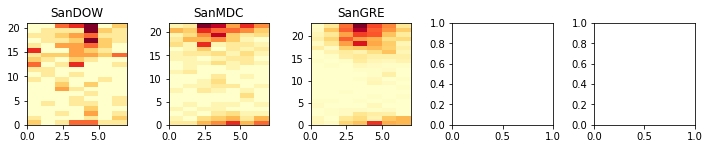

In [16]:
plot_heat_grid_community( inct[ ( inct.legend == 'SEX CRIMES') & (inct.desc == 'PROSTITUTION' ) ], 
                         communities=['SanDOW','SanMDC','SanGRE'])

Burglary shows some interesting patterns -- several of the communities are missing the cluster of incidents in the middle of the workday, and some have much stronger Friday evenings. Our original analysis showed the workday and Friday evening patterns on the same heatmap, but it turns out they are independent, and occur in different communities. 

A guess at the reason is that in the more affluent areas there are more people who work from home or maintain the home, so the burglars have to pick another time. A future analysis could link in Census data to verify this hypothesis. 

However, breaking the maps out by residential versus commercial shows that the Friday effect is strongest for commercial burglaries, and that the weekday pattern appears only in the residential burglaries. The later should be expected -- burglars aren't likely to hit a business while it is open -- but the former, the Friday expect, could have shown in residential burglaries too. 

There are a few communities that have a Friday pattern: Pacific Beach ( SanPCF ) and La Jolla ( SanLAJ ).

## Burglary

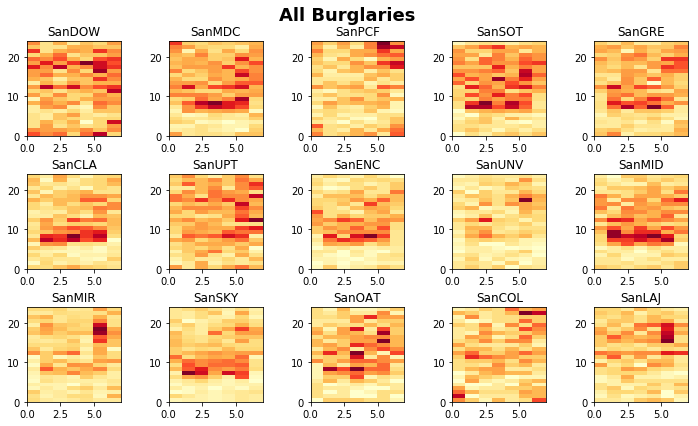

In [17]:
plot_heat_grid_community( inct[inct.legend == 'BURGLARY'], communities=communities, title='All Burglaries', 
                         filename='all-burglaries-by-community.png')

### Commercial Burglaries

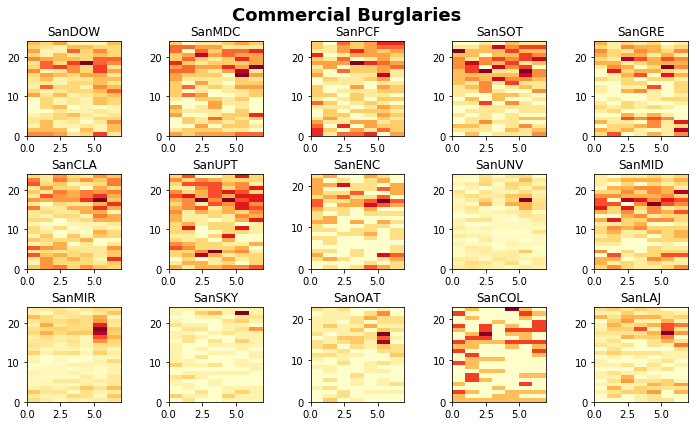

In [18]:
plot_heat_grid_community( inct[inct.desc == 'COMMERCIAL BURGLARY'], communities=communities, title='Commercial Burglaries', 
                         filename='commercial-burglaries-by-community.png')

### Residential Burglaries

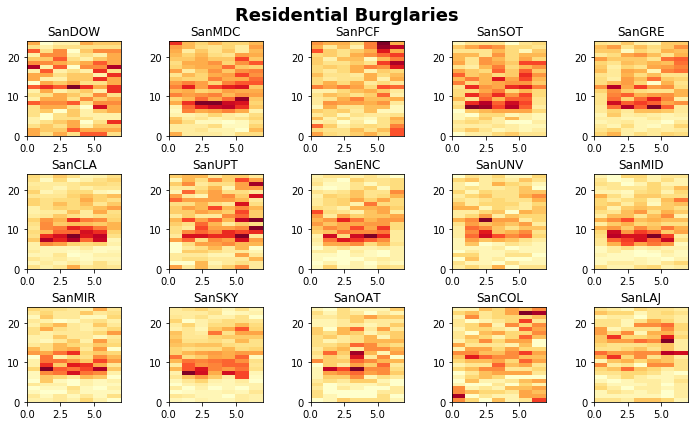

In [19]:
plot_heat_grid_community( inct[inct.desc == 'RESIDENTIAL BURGLARY'], communities=communities, title='Residential Burglaries', 
                         filename='residential-burglaries-by-community.png')

## DUI

DUIs however, look pretty much the same everywhere, although some communities get started earlier. The communities that have more "noise" in the middle of the map, rather than being solid yellow, are ones that have fewer DUIs; in the comunities with a lot of DUIs, such as SanDOW and SanPCF the large number of nighttime DUIs swamps those during the day. 

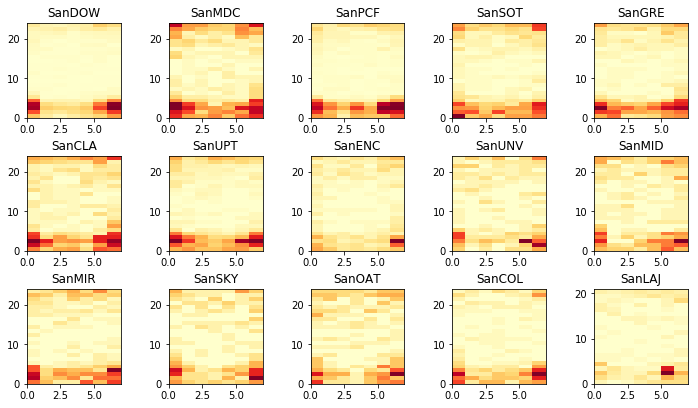

In [20]:
plot_heat_grid_community( inct[inct.legend == 'DUI'], communities=communities)

## Theft / Larceny

The patterns for Theft are more subtle, but seem to be connected to whether the community has an active nightlife, where more of the interactions between people occur in the evening. 

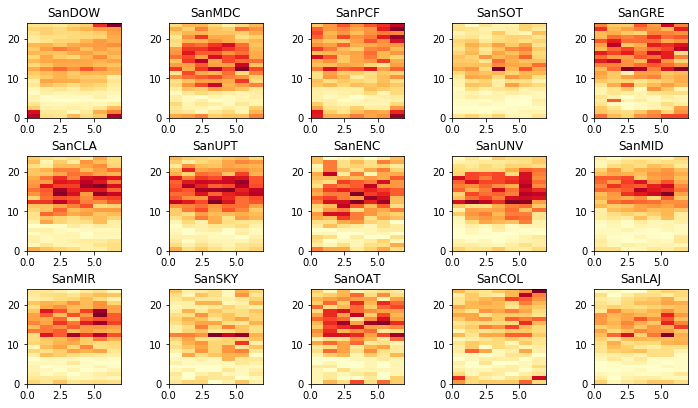

In [21]:
plot_heat_grid_community( inct[inct.legend == 'THEFT/LARCENY'], communities=communities)